In [1]:
!pip install dynet
!git clone https://github.com/neubig/nn4nlp-code.git

    100% |████████████████████████████████| 27.8MB 1.5MB/s 
    100% |████████████████████████████████| 3.4MB 12.8MB/s 
Cloning into 'nn4nlp-code'...
remote: Counting objects: 372, done.
remote: Total 372 (delta 0), reused 0 (delta 0), pack-reused 372
Receiving objects: 100% (372/372), 6.33 MiB | 18.20 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [0]:
import numpy as np
import matplotlib
# matplotlib.use('Agg')

from matplotlib.font_manager import FontProperties
from matplotlib import rcParams
import pdb as pdb
import matplotlib.pyplot as plt
import six


# if you are outputting cjk, matplotlib needs to first load a cjk font.
# you can figure out how to find a non-latin font on your system here:
# > https://matplotlib.org/users/text_props.html#text-with-non-latin-glyphs
# for example
#
# 1. run in terminal
# $ fc-list :lang=ja family
# -> displays "MS Gothic" as one of the options
#
# 2. add to code here:
# matplotlib.rcParams['font.family'].insert(0, 'MS Gothic')

def plot_attention(src_words, trg_words, attention_matrix, file_name=None):
  """This takes in source and target words and an attention matrix (in numpy format)
  and prints a visualization of this to a file.
  :param src_words: a list of words in the source
  :param trg_words: a list of target words
  :param attention_matrix: a two-dimensional numpy array of values between zero and one,
    where rows correspond to source words, and columns correspond to target words
  :param file_name: the name of the file to which we write the attention
  """
  fig, ax = plt.subplots()
  #a lazy, rough, approximate way of making the image large enough
  fig.set_figwidth(int(len(trg_words)*.6))

  # put the major ticks at the middle of each cell
  ax.set_xticks(np.arange(attention_matrix.shape[1]) + 0.5, minor=False)
  ax.set_yticks(np.arange(attention_matrix.shape[0]) + 0.5, minor=False)
  ax.invert_yaxis()

  # label axes by words
  ax.set_xticklabels(trg_words, minor=False)
  ax.set_yticklabels(src_words, minor=False)
  ax.xaxis.tick_top()
  plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='right')
  # draw the heatmap
  plt.pcolor(attention_matrix, cmap=plt.cm.Blues, vmin=0, vmax=1)
  plt.colorbar()

  if file_name != None:
    plt.savefig(file_name, dpi=100)
  else:
    plt.show()
  plt.close()

In [0]:
from __future__ import print_function
import time

from collections import defaultdict
# from plot_attention import plot_attention
import random
import math
import sys
import argparse

import dynet as dy
import numpy as np
import pdb

In [0]:
#some of this code borrowed from Qinlan Shen's attention from the MT class last year
#much of the beginning is the same as the text retrieval
# format of files: each line is "word1 word2 ..." aligned line-by-line
train_src_file = "nn4nlp-code/data/parallel/train.ja"
train_trg_file = "nn4nlp-code/data/parallel/train.en"
dev_src_file = "nn4nlp-code/data/parallel/dev.ja"
dev_trg_file = "nn4nlp-code/data/parallel/dev.en"
test_src_file = "nn4nlp-code/data/parallel/test.ja"
test_trg_file = "nn4nlp-code/data/parallel/test.en"

w2i_src = defaultdict(lambda: len(w2i_src))
w2i_trg = defaultdict(lambda: len(w2i_trg))


# Creates batches where all source sentences are the same length
def create_batches(sorted_dataset, max_batch_size):
    source = [x[0] for x in sorted_dataset]
    src_lengths = [len(x) for x in source]
    batches = []
    prev = src_lengths[0]
    prev_start = 0
    batch_size = 1
    for i in range(1, len(src_lengths)):
        if src_lengths[i] != prev or batch_size == max_batch_size:
            batches.append((prev_start, batch_size))
            prev = src_lengths[i]
            prev_start = i
            batch_size = 1
        else:
            batch_size += 1
    return batches


def read(fname_src, fname_trg):
    """
    Read parallel files where each line lines up
    """
    with open(fname_src, "r") as f_src, open(fname_trg, "r") as f_trg:
        for line_src, line_trg in zip(f_src, f_trg):
            #need to append EOS tags to at least the target sentence
            sent_src = [w2i_src[x] for x in line_src.strip().split() + ['</s>']] 
            sent_trg = [w2i_trg[x] for x in ['<s>'] + line_trg.strip().split() + ['</s>']] 
            yield (sent_src, sent_trg)

# Read the data
train = list(read(train_src_file, train_trg_file))
unk_src = w2i_src["<unk>"]
eos_src = w2i_src['</s>']
w2i_src = defaultdict(lambda: unk_src, w2i_src)
unk_trg = w2i_trg["<unk>"]
eos_trg = w2i_trg['</s>']
sos_trg = w2i_trg['<s>']
w2i_trg = defaultdict(lambda: unk_trg, w2i_trg)
i2w_trg = {v: k for k, v in w2i_trg.items()}
i2w_src = {v: k for k, v in w2i_src.items()}

nwords_src = len(w2i_src)
nwords_trg = len(w2i_trg)
dev = list(read(dev_src_file, dev_trg_file))
test = list(read(test_src_file, test_trg_file))

In [5]:
# DyNet Starts
model = dy.Model()
trainer = dy.AdamTrainer(model)

# Model parameters
EMBED_SIZE = 64
HIDDEN_SIZE = 128
ATTENTION_SIZE = 128
BATCH_SIZE = 16

#Especially in early training, the model can generate basically infinitly without generating an EOS
#have a max sent size that you end at
MAX_SENT_SIZE = 50

# Lookup parameters for word embeddings
LOOKUP_SRC = model.add_lookup_parameters((nwords_src, EMBED_SIZE))
LOOKUP_TRG = model.add_lookup_parameters((nwords_trg, EMBED_SIZE))

# Word-level LSTMs

#we want a bidirectional LSTM for attention over the source
LSTM_SRC = dy.BiRNNBuilder(1, EMBED_SIZE, HIDDEN_SIZE, model, dy.LSTMBuilder)
LSTM_TRG_BUILDER = dy.LSTMBuilder(1, EMBED_SIZE, HIDDEN_SIZE, model, dy.LSTMBuilder)

#hidden size*3 to hidden size-layer before softmax in attention
W_m_p = model.add_parameters((HIDDEN_SIZE, HIDDEN_SIZE*2))
b_m_p = model.add_parameters(HIDDEN_SIZE)

#the softmax from the hidden size 
W_sm_p = model.add_parameters((nwords_trg, HIDDEN_SIZE))         # Weights of the softmax
b_sm_p = model.add_parameters((nwords_trg))                   # Softmax bias

#parameters for attention
w1_att_src_p = model.add_parameters((ATTENTION_SIZE, HIDDEN_SIZE))
w1_att_tgt_p = model.add_parameters((ATTENTION_SIZE, HIDDEN_SIZE))
w2_att_p = model.add_parameters((ATTENTION_SIZE))

def calc_attention(src_output_matrix, tgt_output_embedding, fixed_attentional_component):
    w1_att_src = dy.parameter(w1_att_src_p)
    w1_att_tgt = dy.parameter(w1_att_tgt_p)
    w2_att = dy.parameter(w2_att_p)
    a_t = dy.transpose(dy.tanh(dy.colwise_add(fixed_attentional_component, w1_att_tgt * tgt_output_embedding))) * w2_att
    alignment = dy.softmax(a_t)
    att_output = src_output_matrix * alignment
    return att_output, alignment

def calc_loss(sents):
    dy.renew_cg()

    # Transduce all batch elements with an LSTM
    src_sents = [x[0] for x in sents]
    tgt_sents = [x[1] for x in sents]
    src_cws = []

    src_len = [len(sent) for sent in src_sents]        
    max_src_len = np.max(src_len)
    num_words = 0

    for i in range(max_src_len):
        src_cws.append([sent[i] for sent in src_sents])


    #get the outputs of the first LSTM
    src_outputs = [dy.concatenate([x.output(), y.output()]) for x,y in LSTM_SRC.add_inputs([dy.lookup_batch(LOOKUP_SRC, cws) for cws in src_cws])]
    src_output = src_outputs[-1]

    #gets the parameters for the attention
    src_output_matrix = dy.concatenate_cols(src_outputs)
    w1_att_src = dy.parameter(w1_att_src_p)
    fixed_attentional_component = w1_att_src * src_output_matrix

    #now decode
    all_losses = []

    # Decoder
    #need to mask padding at end of sentence
    tgt_cws = []
    tgt_len = [len(sent) for sent in sents]
    max_tgt_len = np.max(tgt_len)
    masks = []

    for i in range(max_tgt_len):
        tgt_cws.append([sent[i] if len(sent) > i else eos_trg for sent in tgt_sents])
        mask = [(1 if len(sent) > i else 0) for sent in tgt_sents]
        masks.append(mask)
        num_words += sum(mask)



    current_state = LSTM_TRG_BUILDER.initial_state().set_s([src_output, dy.tanh(src_output)])
    prev_words = tgt_cws[0]
    W_sm = dy.parameter(W_sm_p)
    b_sm = dy.parameter(b_sm_p)

    W_m = dy.parameter(W_m_p)
    b_m = dy.parameter(b_m_p)

    for next_words, mask in zip(tgt_cws[1:], masks):
        #feed the current state into the 
        current_state = current_state.add_input(dy.lookup_batch(LOOKUP_TRG, prev_words))
        output_embedding = current_state.output()
        att_output, _ = calc_attention(src_output_matrix, output_embedding, fixed_attentional_component)
        middle_expr = dy.tanh(dy.affine_transform([b_m, W_m, dy.concatenate([output_embedding, att_output])]))
        s = dy.affine_transform([b_sm, W_sm, middle_expr])
        loss = (dy.pickneglogsoftmax_batch(s, next_words))
        mask_expr = dy.inputVector(mask)
        mask_expr = dy.reshape(mask_expr, (1,),len(sents))
        mask_loss = loss * mask_expr
        all_losses.append(mask_loss)
        prev_words = next_words
    return dy.sum_batches(dy.esum(all_losses)), num_words

def generate(sent):
    dy.renew_cg()

    # Transduce all batch elements with an LSTM
    src = sent

    #get the output of the first LSTM
    src_outputs =  [dy.concatenate([x.output(), y.output()]) for x,y in LSTM_SRC.add_inputs([LOOKUP_SRC[word] for word in src])]

    src_output = src_outputs[-1]

    #gets the parameters for the attention
    src_output_matrix = dy.concatenate_cols(src_outputs)
    w1_att_src = dy.parameter(w1_att_src_p)
    fixed_attentional_component = w1_att_src * src_output_matrix



    #generate until a eos tag or max is reached
    current_state = LSTM_TRG_BUILDER.initial_state().set_s([src_output, dy.tanh(src_output)])

    prev_word = sos_trg
    trg_sent = []
    attention_matrix = []
    W_sm = dy.parameter(W_sm_p)
    b_sm = dy.parameter(b_sm_p)

    W_m = dy.parameter(W_m_p)
    b_m = dy.parameter(b_m_p)



    for i in range(MAX_SENT_SIZE):
        #feed the previous word into the lstm, calculate the most likely word, add it to the sentence
        current_state = current_state.add_input(LOOKUP_TRG[prev_word])
        output_embedding = current_state.output()
        att_output, alignment = calc_attention(src_output_matrix, output_embedding, fixed_attentional_component)
        attention_matrix.append(alignment)
        middle_expr = dy.tanh(dy.affine_transform([b_m, W_m, dy.concatenate([output_embedding, att_output])]))
        s = dy.affine_transform([b_sm, W_sm, middle_expr])
        probs = (-dy.log_softmax(s)).value()
        next_word = np.argmax(probs)

        if next_word == eos_trg:
            break
        prev_word = next_word
        trg_sent.append(i2w_trg[next_word])
    return trg_sent, dy.concatenate_cols(attention_matrix).value()

# On this particular data set, training starts to overfit after 5 epochs,
# so we only do 5. The better way to do this is to check dev perplexity and
# top when it ceases to get better.
for ITER in range(5):
  # Perform training
  train.sort(key=lambda t: len(t[0]), reverse=True)
  dev.sort(key=lambda t: len(t[0]), reverse=True)
  train_order = create_batches(train, BATCH_SIZE) 
  dev_order = create_batches(dev, BATCH_SIZE)
  train_words, train_loss = 0, 0.0
  start_time = time.time()
  for sent_id, (start, length) in enumerate(train_order):
    train_batch = train[start:start+length]
    my_loss, num_words = calc_loss(train_batch)
    train_loss += my_loss.value()
    train_words += num_words
    my_loss.backward()
    trainer.update()
    if (sent_id+1) % 5000 == 0:
      print("--finished %r sentences" % (sent_id+1))
  print("iter %r: train loss/word=%.4f, ppl=%.4f, time=%.2fs" % (ITER, train_loss/train_words, math.exp(train_loss/train_words), time.time()-start_time))
  # Evaluate on dev set
  dev_words, dev_loss = 0, 0.0
  start_time = time.time()
  for sent_id, (start, length) in enumerate(dev_order):
    dev_batch = dev[start:start+length]
    my_loss, num_words = calc_loss(dev_batch)
    dev_loss += my_loss.value()
    dev_words += num_words
    trainer.update()
  print("iter %r: dev loss/word=%.4f, ppl=%.4f, time=%.2fs" % (ITER, dev_loss/dev_words, math.exp(dev_loss/dev_words), time.time()-start_time))



iter 0: train loss/word=2.0012, ppl=7.3982, time=31.56s
iter 0: dev loss/word=2.1895, ppl=8.9311, time=0.86s
iter 1: train loss/word=1.4908, ppl=4.4406, time=31.99s
iter 1: dev loss/word=1.9372, ppl=6.9391, time=0.90s
iter 2: train loss/word=1.3135, ppl=3.7193, time=32.42s
iter 2: dev loss/word=1.8502, ppl=6.3613, time=0.87s
iter 3: train loss/word=1.1743, ppl=3.2360, time=31.50s
iter 3: dev loss/word=1.8375, ppl=6.2810, time=0.86s
iter 4: train loss/word=1.0486, ppl=2.8538, time=31.33s
iter 4: dev loss/word=1.8665, ppl=6.4654, time=0.85s


In [0]:
#now let's generate one sentence from test, and visualize it's attention
src = test[0][0]
tgt = test[0][1]
output_sent, attention_matrix = generate(src)
#note: this can break for long sentences with long words
plot_attention([i2w_src[x] for x in src], output_sent, attention_matrix, 'attention_matrix.png')

In [0]:
from PIL import Image

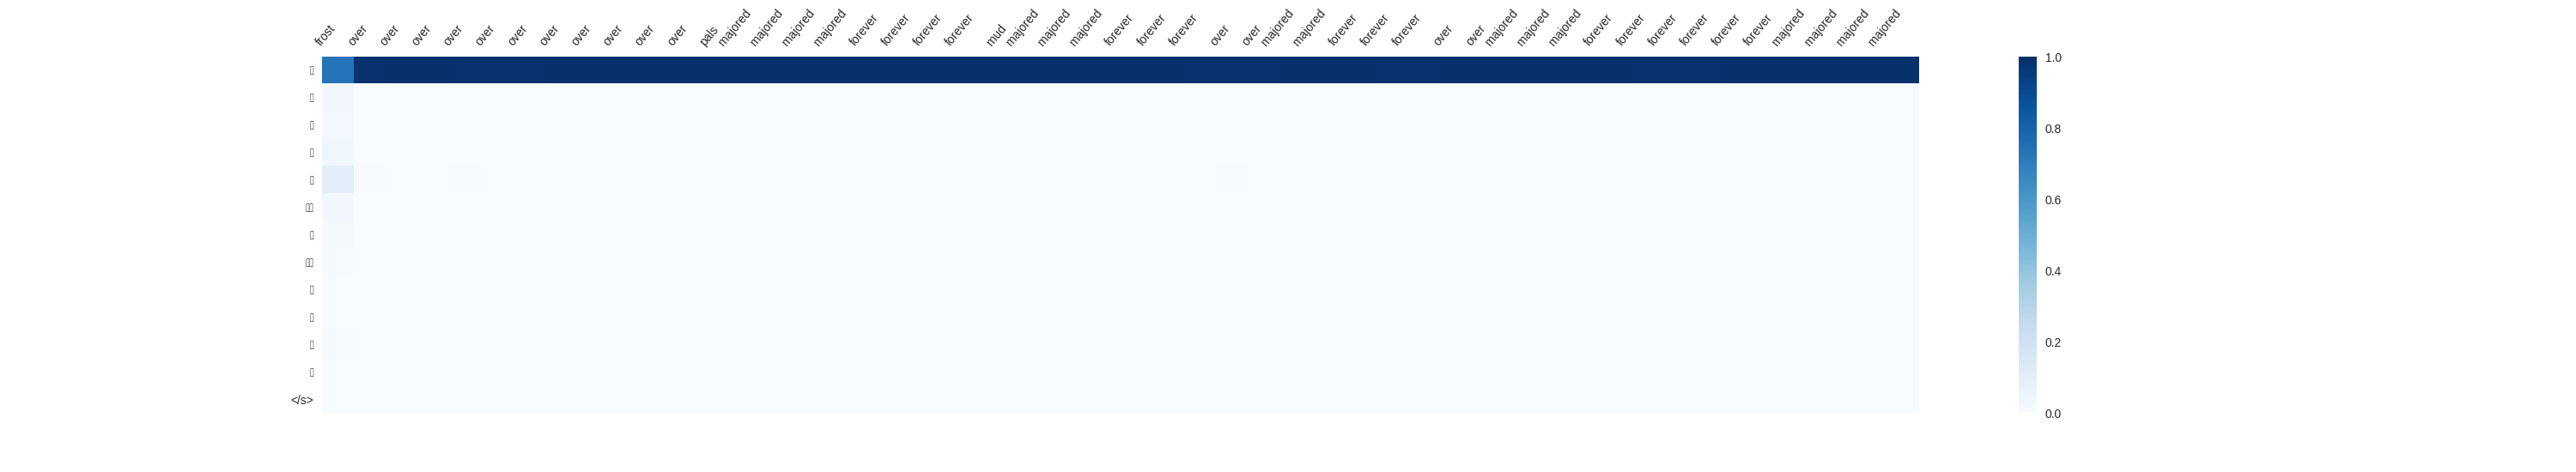

In [9]:
Image.open('attention_matrix.png')